# Import moduls

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd

# moduls for KNN_color()
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# modul for significant_color_knn()
from collections import Counter

# Functions

In [3]:
def img_preprocessing(img):
    datas = img
    newData = []
    cutoff = 200
    
    # cutoff 
    for item in datas:
        if item[0] >= cutoff and item[1] >= cutoff and item[2] >= cutoff:
            newData.append((255, 255, 255, 0)) # if RGB value is over cutoff, consider as background (white)
        else:
            newData.append(item)  # don't change others
    
    img_pixel = pd.DataFrame(np.array(newData))
    drop_idx = img_pixel[img_pixel[3] == 0].index  # if pixel is transparent, dorp
    img_pixel = img_pixel.drop(drop_idx)
    pixels = img_pixel.drop(columns=[3], axis=1)
    pixels.columns = ['R', 'G', 'B']
    pixels = pixels.reset_index(drop=True)
    
    return pixels

In [4]:
def KNN_color(rgb_data):
    X = rgb_data[['R', 'G', 'B']]
    y = rgb_data['index']
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y,train_size = 0.7,test_size = 0.3,random_state = 0)
    
    knn = KNeighborsClassifier(n_neighbors=16)  # set KNN model
    knn.fit(X_train, y_train)
    
    print('train set score:', knn.score(X_train, y_train))
    print('test set score:', knn.score(X_test, y_test))
    
    n_test = len(y_test)
    y_predict = knn.predict(X_test)
    
    return knn

In [5]:
def significant_color_knn(pixels):
    colors = ['aqua','black', 'blue', 'fuchsia', 'green', 'lime', 'maroon', 'navy', 'red', 'white', 'yellow']
    
    # if the image only contains white color
    # image preprocessing eliminates white pixels, so if the image only has white color, no pixel will remain
    if len(pixels) == 0:
        return 9
    
    pred_color = knn.predict(pixels)  # identify color using learned model
    color_counts = Counter(knn.predict(pixels))  # count label
    detected = [i for i in color_counts.keys()]  # key of color_counts
    
    det_col = []
    for i in range(len(detected)):  # function for identifiying color name of the key
        det_col.append(colors[detected[i]])
        
    # making into single dataframe of the rgb values and the result
    predicted = pd.DataFrame(pred_color)
    predicted.columns = ['index']
    predicted = pixels.join(predicted)
    
    # index of most significant color
    for k, v in color_counts.items():
        if v == max(color_counts.values()):
            max_idx = k
            
    return max_idx

# Test

In [6]:
# load dataset
X = np.load("./dataset/1100_clothing_img.npy")
y = np.load("./dataset/1100_clothing_color.npy")

In [7]:
rgb_data = pd.read_csv('./colorChart/augmented_color_chart_11.csv')  # data to learn (augmented)
html = pd.read_csv('./colorChart/colorChart_11.csv')  # data to identify color (non-augmented data)

In [8]:
print(X.shape)
print(y.shape)

(1100, 16384, 4)
(1100,)


In [9]:
%%time
knn = KNN_color(rgb_data = rgb_data)

train set score: 0.99052809134553
test set score: 0.9881961259079903

test data length: 3304
Number of data that matched the prediction: 3265
match rate: 98.82 %
CPU times: total: 406 ms
Wall time: 378 ms


In [10]:
result = []

In [11]:
%%time

for i in range(len(X)):
    img = X[i]
    pixels = img_preprocessing(img = img)
    identified_color = significant_color_knn(pixels = pixels)
    result.append(identified_color)
    
    if (i+1) % 100 == 0:
        print(f"{i+1} images processed")

100 images processed
200 images processed
300 images processed
400 images processed
500 images processed
600 images processed
700 images processed
800 images processed
900 images processed
1000 images processed
1100 images processed
CPU times: total: 9min 13s
Wall time: 9min 14s


In [13]:
len(result)

1100

In [15]:
KNN_pred = np.array(result)
np.save("./1100_KNN_result", KNN_pred)

# Check accuracy

In [58]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
from matplotlib import pyplot as plt

In [62]:
np.linalg.norm(y-result)

116.91022196540386

In [17]:
conf_mx = confusion_matrix(y, result)
conf_mx

array([[50,  0,  0,  0,  0,  0,  0,  5,  0, 45,  0],
       [ 0, 99,  0,  0,  1,  0,  0,  0,  0,  0,  0],
       [20,  0, 24,  0,  0,  0,  0, 45,  0, 11,  0],
       [ 0,  0,  0, 53,  0,  0,  2,  0, 35, 10,  0],
       [ 2, 42,  0,  0, 44,  4,  0,  0,  0,  4,  4],
       [ 1,  0,  0,  0,  2, 10,  0,  0,  0, 23, 64],
       [ 0, 34,  0,  0,  0,  0, 64,  0,  2,  0,  0],
       [ 8, 68,  7,  0,  0,  0,  0, 15,  0,  2,  0],
       [ 0,  0,  0,  0,  0,  0, 26,  0, 74,  0,  0],
       [ 0,  1,  0,  0,  1,  0,  3,  1,  1, 92,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 12, 88]], dtype=int64)

In [18]:
label = ['aqua','black', 'blue', 'fuchsia', 'green', 'lime', 'maroon', 'navy', 'red', 'white', 'yellow']

In [39]:
y_plot = y.reshape(-1, 1)
result_plot = KNN_pred.reshape(-1, 1)

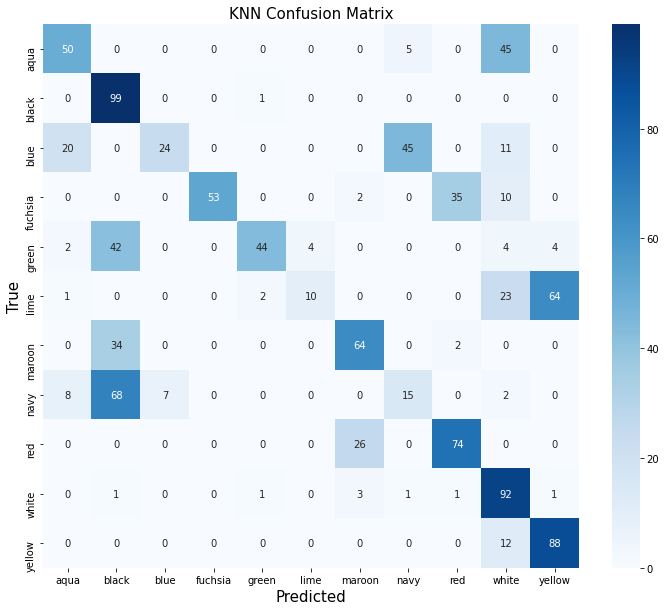

In [57]:
plt.figure(figsize=(12, 10)) 
sns.heatmap(conf_mx, annot=True, cmap=plt.cm.Blues, fmt='d')
plt.xticks(np.arange(0.5, len(label), 1), labels=label)
plt.yticks(np.arange(0.5, len(label), 1), labels=label)
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('True', fontsize=15)
plt.title('KNN Confusion Matrix', fontsize=15)
plt.savefig('KNN_confusion_matrix.png')
plt.show()

In [60]:
accuracy_score(y, result)

0.5572727272727273

In [54]:
print(classification_report(y, result))

              precision    recall  f1-score   support

           0       0.62      0.50      0.55       100
           1       0.41      0.99      0.58       100
           2       0.77      0.24      0.37       100
           3       1.00      0.53      0.69       100
           4       0.92      0.44      0.59       100
           5       0.71      0.10      0.18       100
           6       0.67      0.64      0.66       100
           7       0.23      0.15      0.18       100
           8       0.66      0.74      0.70       100
           9       0.46      0.92      0.62       100
          10       0.56      0.88      0.68       100

    accuracy                           0.56      1100
   macro avg       0.64      0.56      0.53      1100
weighted avg       0.64      0.56      0.53      1100



* precision: 정밀도. 예측이 실제로 정답인 확률. (예측과 정답이 일치 / 해당 label이라고 예측한 수)
* recall: 재현도. 정답 중 정답으로 예측된 확률. (예측과 정답이 일치 / 정답의 수 = 100)
* f1: 정밀도와 재현도의 가중 조화평균